<h1>Ion Switching Advanced EDA and Prediction</h1>

<img src="https://storage.googleapis.com/kaggle-media/competitions/Liverpool/ion%20image.jpg"></img>

<br>

# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Prepare the data analysis</a>  
- <a href='#3'>Data exploration</a>   
- <a href='#4'>Feature engineering</a>
- <a href='#5'>Model</a>
- <a href='#6'>Submission</a>  
- <a href='#7'>References</a>

# <a id='1'>Introduction</a>  

Ion channels are pore-forming membrane proteins that allow ions to pass through the channel pore. Their functions include establishing a resting membrane potential, shaping action potentials and other electrical signals by gating the flow of ions across the cell membrane, controlling the flow of ions across secretory and epithelial cells, and regulating cell volume. Ion channels are present in the membranes of all excitable cells.

When ion channels open, they pass electric currents. Existing methods of detecting these state changes are slow and laborious. Humans must supervise the analysis, which imparts considerable bias, in addition to being tedious. These difficulties limit the volume of ion channel current analysis that can be used in research.

The University of Liverpool’s Institute of Ageing and Chronic Disease is working to advance ion channel research. Their team of scientists have asked for Kagglers help. In this competition, we use ion channel data to better model automatic identification methods. 

The data in train and test are actually batches of 50,000 values, sampled at 0.1 ms, i.e. a total of 50 sec./batch, totally 100 batches in train and 40 batches in test.


# <a id='2'>Prepare the data analysis</a>  

## Include packages

In [1]:
import os
import gc
import numpy as np
import pandas as pd
import time
import math
from numba import jit
from math import log, floor
import scipy
from scipy import signal
from scipy.signal import butter, deconvolve
from sklearn.neighbors import KDTree
from pathlib import Path
from sklearn.utils import shuffle
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import lightgbm as lgb
from tqdm import tqdm
from sklearn.model_selection import GroupKFold, KFold
from sklearn.metrics import cohen_kappa_score, accuracy_score, mean_squared_error, f1_score

## Read the data

We read train, test and submission files.

In [2]:
DATA_PATH = "../input/liverpool-ion-switching"

train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
test_df = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
submission_df = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))

# <a id='3'>Data exploration</a>  


## Glimpse the data

In [3]:
print(f"Train data: {train_df.shape}")
print(f"Test data: {test_df.shape}")

Train data: (5000000, 3)
Test data: (2000000, 2)


Inspect few rows of train and test data.

In [4]:
train_df.head()

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


In [5]:
test_df.head()

,time,signal
0,500.0001,-2.6498
1,500.0002,-2.8494
2,500.0003,-2.8600
3,500.0004,-2.4350
4,500.0005,-2.6155


Use `describe` to report statistical info about train and test data.  

Describe train.

In [6]:
train_df.describe()

,time,signal,open_channels
count,5.000000e+06,5.000000e+06,5.000000e+06
mean,2.500001e+02,1.386246e+00,2.726043e+00
std,1.443376e+02,3.336219e+00,2.665051e+00
min,1.000000e-04,-5.796500e+00,0.000000e+00
25%,1.250001e+02,-1.594800e+00,1.000000e+00
50%,2.500000e+02,1.124000e+00,2.000000e+00
75%,3.750000e+02,3.690100e+00,4.000000e+00
max,5.000000e+02,1.324400e+01,1.000000e+01


Describe test.

In [7]:
test_df.describe()

,time,signal
count,2.000000e+06,2.000000e+06
mean,6.000001e+02,-4.259114e-02
std,5.773504e+01,2.505120e+00
min,5.000001e+02,-5.509600e+00
25%,5.500001e+02,-2.470600e+00
50%,6.000000e+02,-3.551000e-01
75%,6.500000e+02,1.783400e+00
max,7.000000e+02,1.081000e+01


The signals are sampled at 0.1 ms time intervals.   
In **train** there are 5M sample data (from 0 to 500 s) and in **test** there are 2M sample data (from 500 to 700 s).  
There are 100 batches of 5 s in train and 40 batches of 5 sec. in test.  
Number of open channels is from 0 to 10, average (including 0) being 2.72.  

## Memory reduction

We will check memory allocation. If we see that the memory exceeds our RAM resources, we might decide to perform memory reduction.

In [8]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024 ** 2 # just added 
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / 1024 ** 2
    percent = 100 * (start_mem - end_mem) / start_mem
    print('Mem. usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'.format(start_mem, end_mem, percent))
    return df

In [9]:
def get_stats(df):
    stats = pd.DataFrame(index=df.columns, columns=['na_count', 'n_unique', 'type', 'memory_usage'])
    for col in df.columns:
        stats.loc[col] = [df[col].isna().sum(), df[col].nunique(dropna=False), df[col].dtypes, df[col].memory_usage(deep=True, index=False) / 1024**2]
    stats.loc['Overall'] = [stats['na_count'].sum(), stats['n_unique'].sum(), None, df.memory_usage(deep=True).sum() / 1024**2]
    return stats

def print_header():
    print('col         conversion        dtype    na    uniq  size')
    print()
    
def print_values(name, conversion, col):
    template = '{:10}  {:16}  {:>7}  {:2}  {:6}  {:1.2f}MB'
    print(template.format(name, conversion, str(col.dtypes), col.isna().sum(), col.nunique(dropna=False), col.memory_usage(deep=True, index=False) / 1024 ** 2))

In [10]:
get_stats(train_df)

,na_count,n_unique,type,memory_usage
time,0,5000000,float64,38.147
signal,0,136341,float64,38.147
open_channels,0,11,int64,38.147
Overall,0,5.13635e+06,NaN,114.441


In [11]:
get_stats(test_df)

,na_count,n_unique,type,memory_usage
time,0,2000000,float64,15.2588
signal,0,113177,float64,15.2588
Overall,0,2.11318e+06,NaN,30.5177


In [12]:
get_stats(submission_df)

,na_count,n_unique,type,memory_usage
time,0,2000000,float64,15.2588
open_channels,0,1,int64,15.2588
Overall,0,2e+06,NaN,30.5177


The memory used is acceptable. We decide to not perform memory reduction for now.

## Signal distribution

We will look now in detail to the signals in both train and test data.  
First we create a function to plot the signal data.

In [13]:
def plot_time_data(data_df, title="Time variation data", color='b'):
    plt.figure(figsize=(18,8))
    plt.plot(data_df["time"], data_df["signal"], color=color)
    plt.title(title, fontsize=24)
    plt.xlabel("Time [sec]", fontsize=20)
    plt.ylabel("Signal", fontsize=20)
    plt.show()

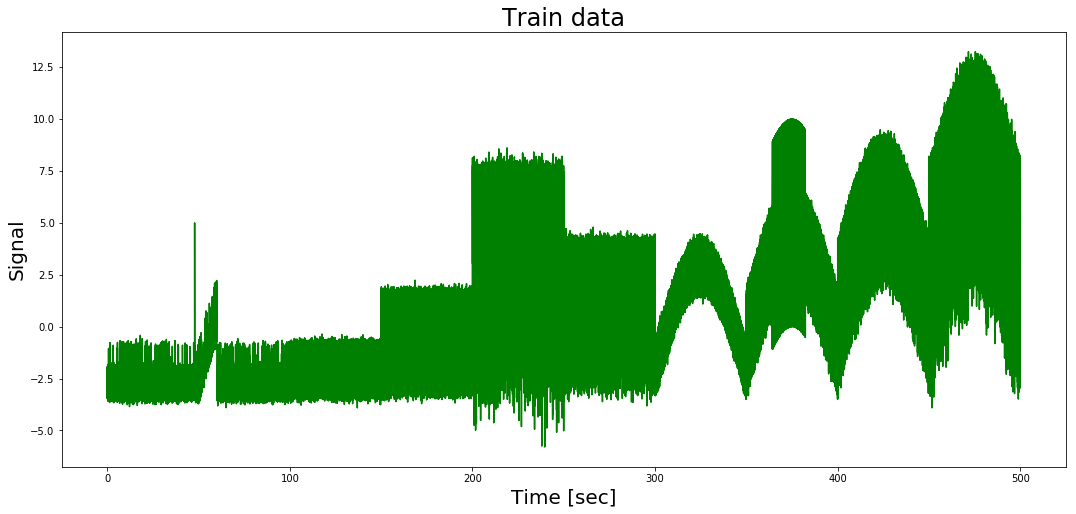

In [14]:
plot_time_data(train_df,"Train data",'g')

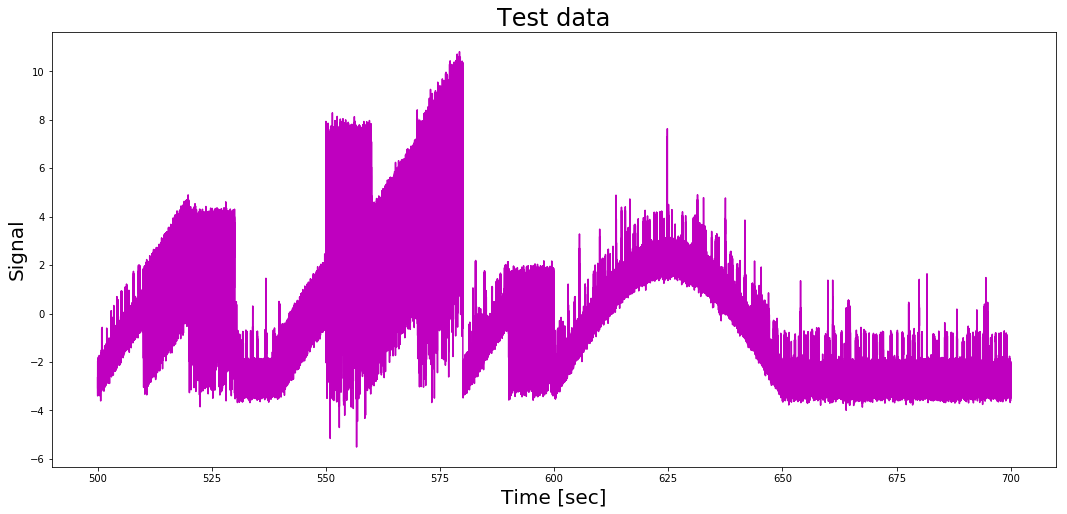

In [15]:
plot_time_data(test_df,"Test data",'m')

For more visibility, we can show samples of data. We will use time intervals of 50 ms.

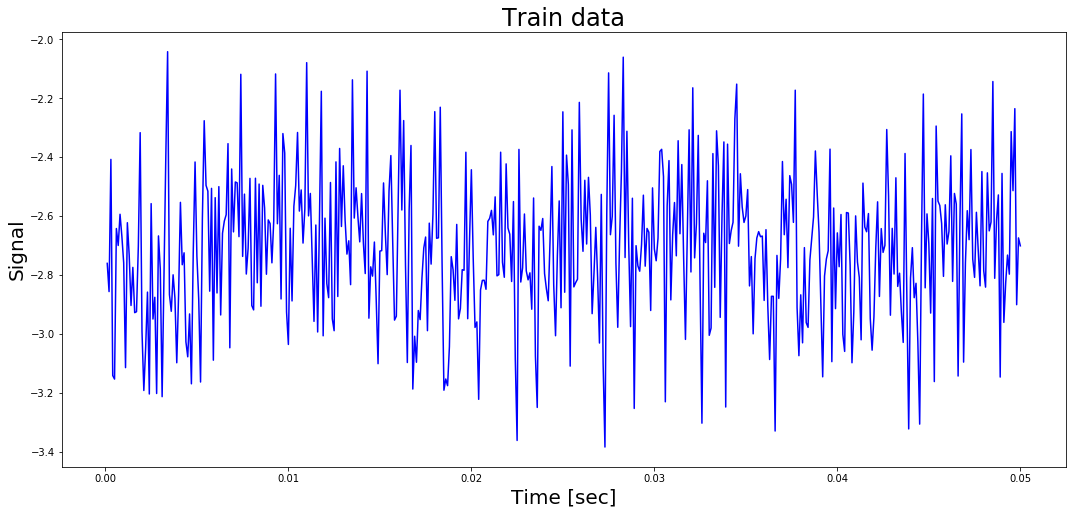

In [16]:
plot_time_data(train_df[0:500],"Train data",'b')

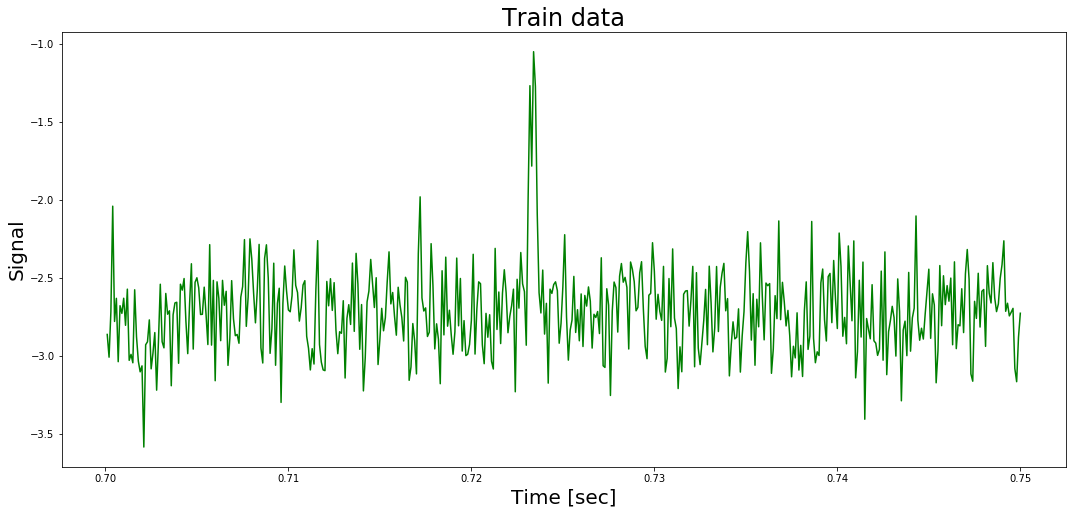

In [17]:
plot_time_data(train_df[7000:7500],"Train data",'g')

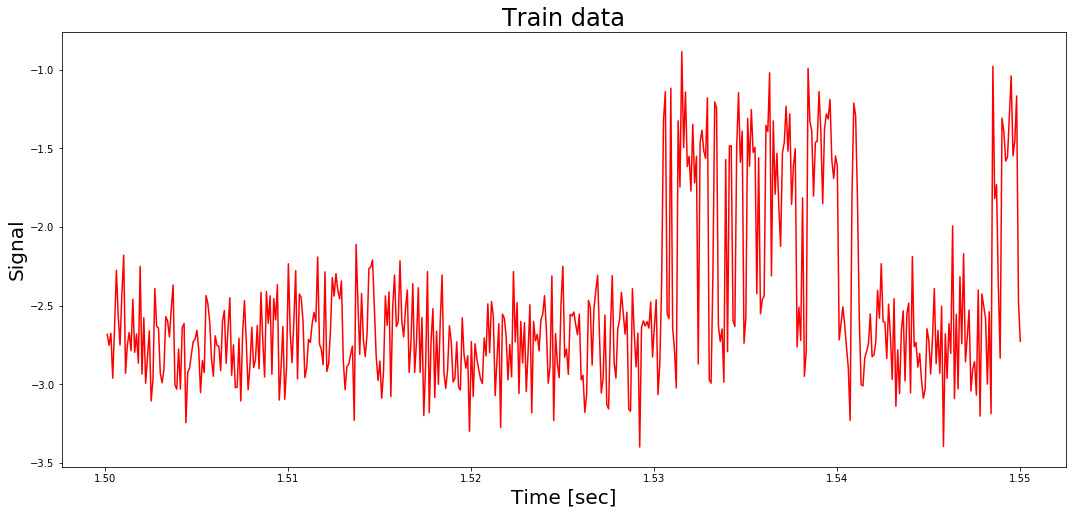

In [18]:
plot_time_data(train_df[15000:15500],"Train data",'r')

## Signal and open channel

We will show now both signal and channel signal on the same graph.  

For this we create a function to show the signal and open channel data.  
We will call this function with various segments of signal samples.

In [19]:
def plot_time_channel_data(data_df, title="Time variation data"):
    plt.figure(figsize=(18,8))
    plt.plot(data_df["time"], data_df["signal"], color='b', label='Signal')
    plt.plot(data_df["time"], data_df["open_channels"], color='r', label='Open channel')
    plt.title(title, fontsize=24)
    plt.xlabel("Time [sec]", fontsize=20)
    plt.ylabel("Signal & Open channel data", fontsize=20)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

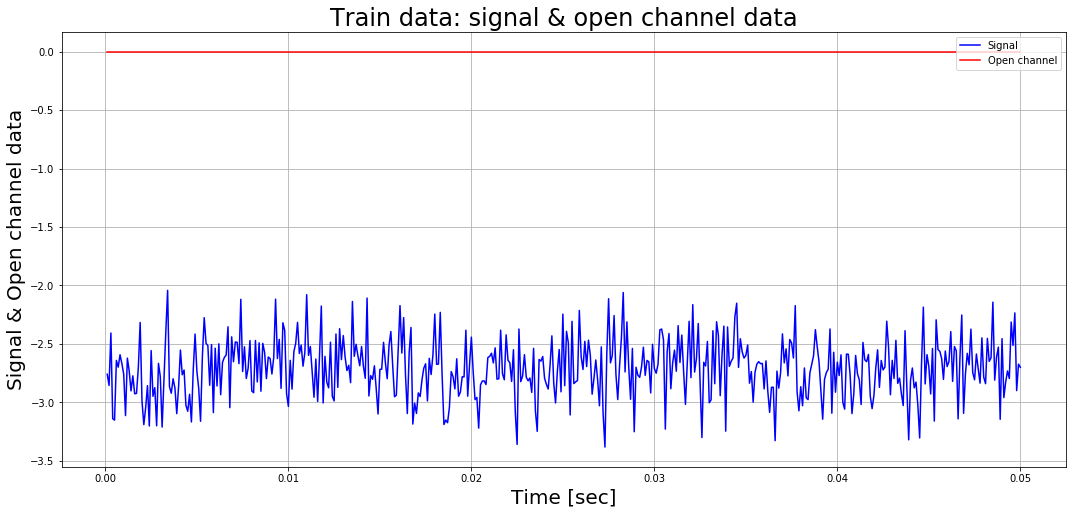

In [20]:
plot_time_channel_data(train_df[0:500],'Train data: signal & open channel data')

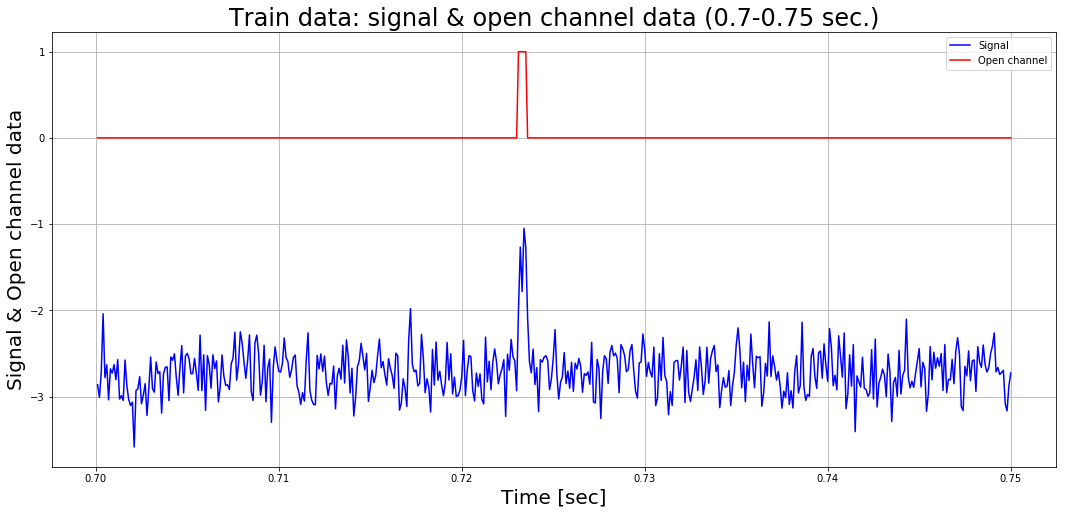

In [21]:
plot_time_channel_data(train_df[7000:7500],'Train data: signal & open channel data (0.7-0.75 sec.)')

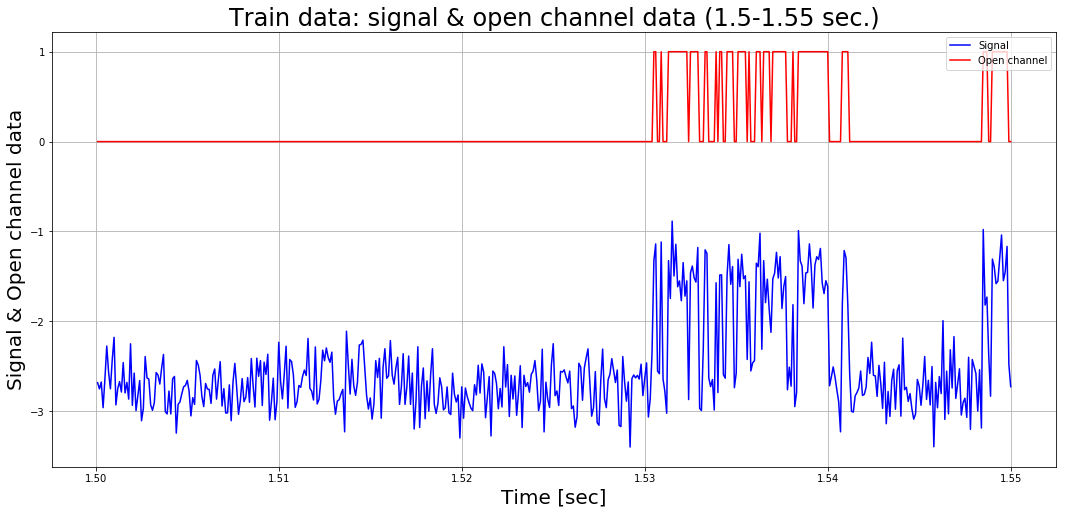

In [22]:
plot_time_channel_data(train_df[15000:15500],'Train data: signal & open channel data (1.5-1.55 sec.)')

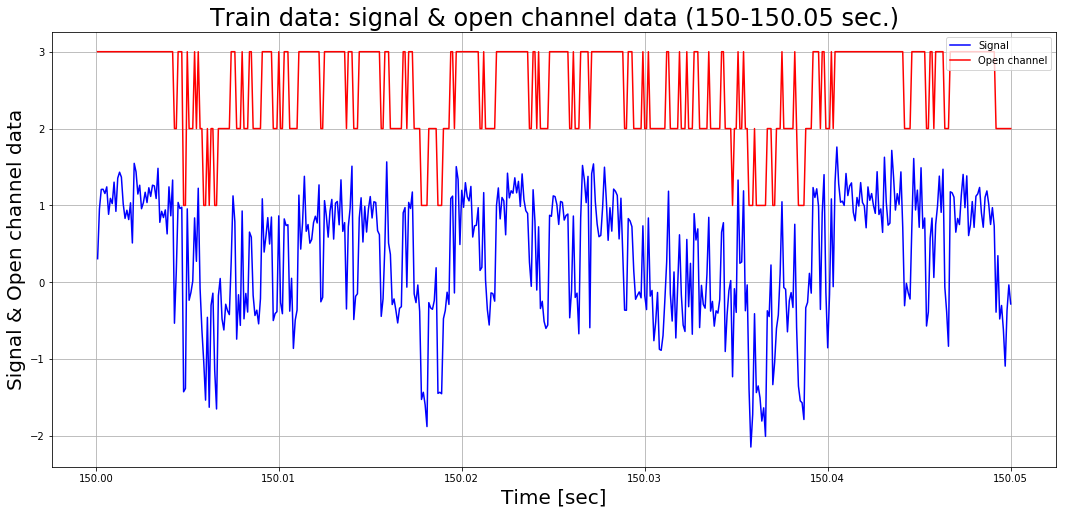

In [23]:
plot_time_channel_data(train_df[1500000:1500500],'Train data: signal & open channel data (150-150.05 sec.)')

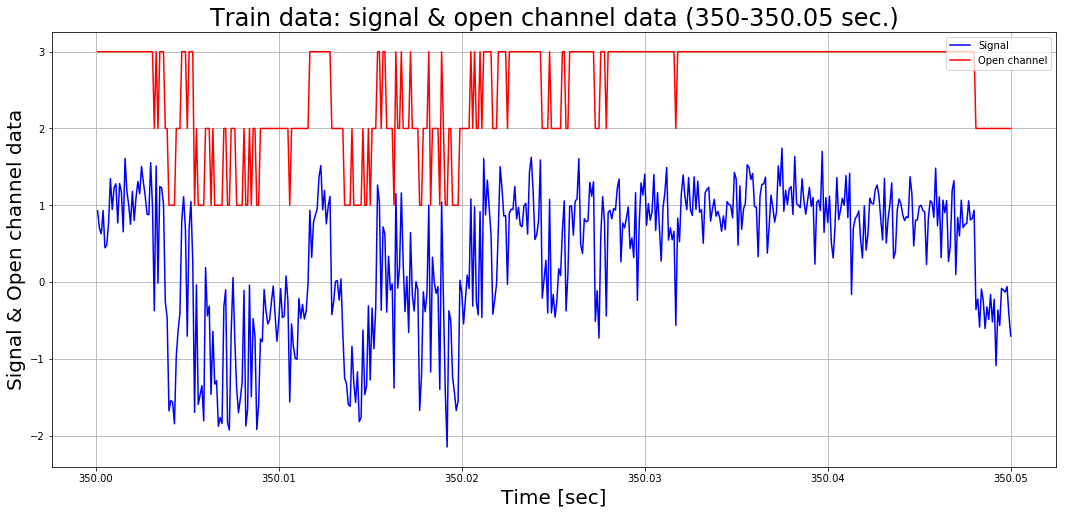

In [24]:
plot_time_channel_data(train_df[3500000:3500500],'Train data: signal & open channel data (350-350.05 sec.)')

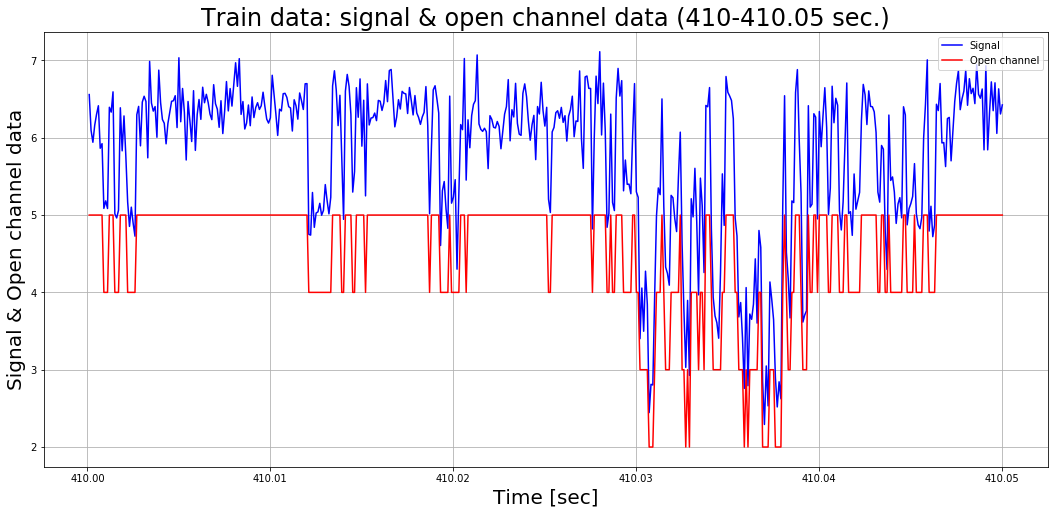

In [25]:
plot_time_channel_data(train_df[4100000:4100500],'Train data: signal & open channel data (410-410.05 sec.)')

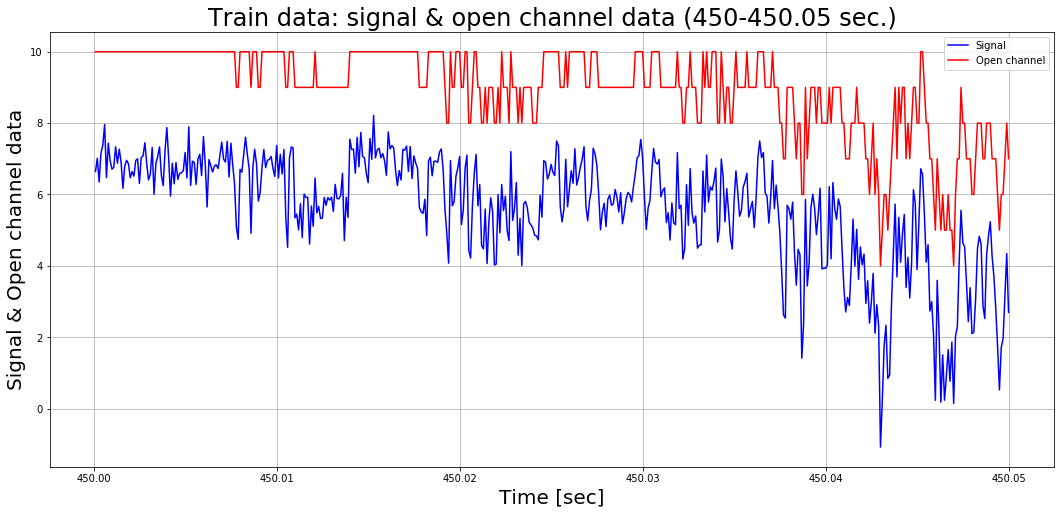

In [26]:
plot_time_channel_data(train_df[4500000:4500500],'Train data: signal & open channel data (450-450.05 sec.)')

## Open channel distribution

Let's look to the open channels distribution only.

In [27]:
def plot_open_channel_count(data_df, title):
    plt.figure(figsize=(8,6))
    sns.countplot(data_df['open_channels'])
    plt.title(title)
    plt.show()

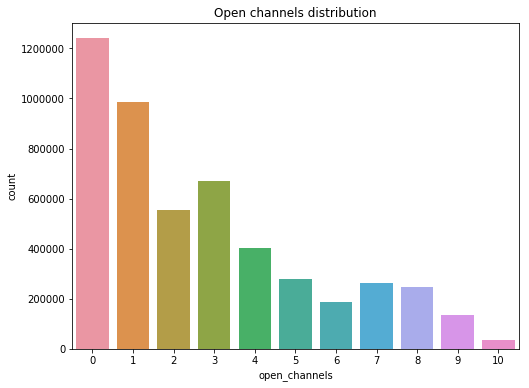

In [28]:
plot_open_channel_count(train_df,'Open channels distribution')

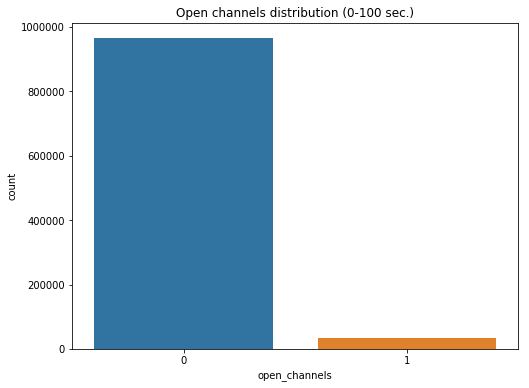

In [29]:
plot_open_channel_count(train_df[0:1000000],'Open channels distribution (0-100 sec.)')

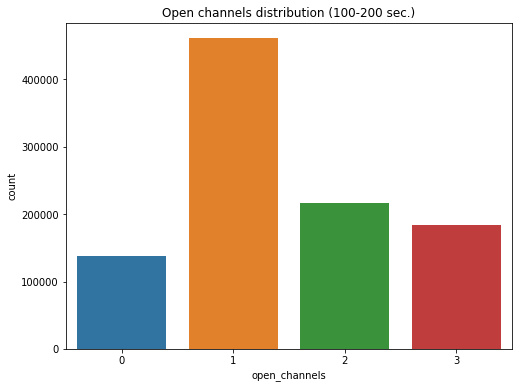

In [30]:
plot_open_channel_count(train_df[1000000:2000000],'Open channels distribution (100-200 sec.)')

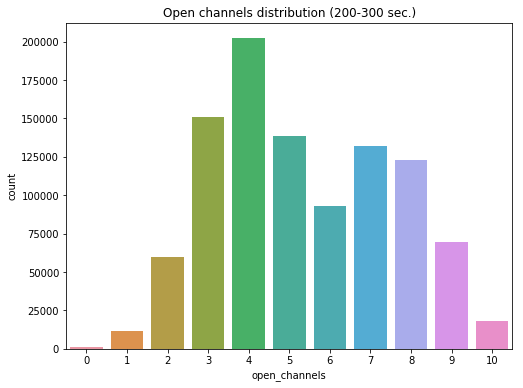

In [31]:
plot_open_channel_count(train_df[2000000:3000000],'Open channels distribution (200-300 sec.)')

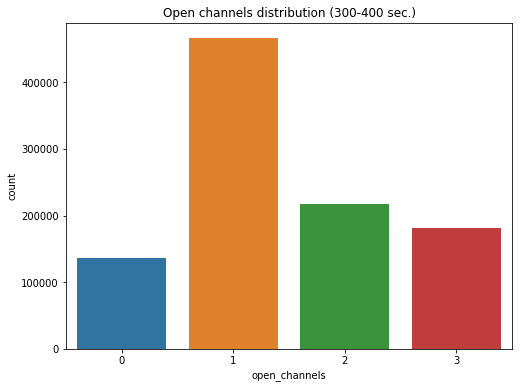

In [32]:
plot_open_channel_count(train_df[3000000:4000000],'Open channels distribution (300-400 sec.)')

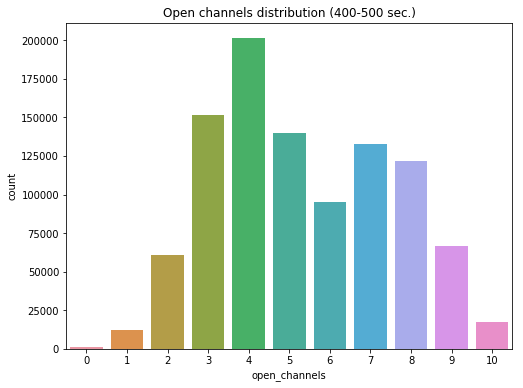

In [33]:
plot_open_channel_count(train_df[4000000:5000000],'Open channels distribution (400-500 sec.)')

## Average denoising

In [34]:
def average_signal_smoothing(signal, kernel_size=3, stride=1):
    sample = []
    start = 0
    end = kernel_size
    while end <= len(signal):
        start = start + stride
        end = end + stride
        sample.extend(np.ones(end - start)*np.mean(signal[start:end]))
    return np.array(sample[::kernel_size])

In [35]:
def plot_signal_signal_smoothed_open_channel(data_df, title):
    sm_df = average_signal_smoothing(data_df["signal"])
    plt.figure(figsize=(18,8))
    plt.plot(data_df["time"], data_df["signal"], color='b', label='Signal')
    plt.plot(data_df["time"][2:], sm_df, color='g', label='Smoothed signal')
    plt.plot(data_df["time"], data_df["open_channels"], color='r', label='Open channel')
    plt.title(title, fontsize=24)
    plt.xlabel("Time [sec]", fontsize=20)
    plt.ylabel("Signal & Open channel data", fontsize=20)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()    

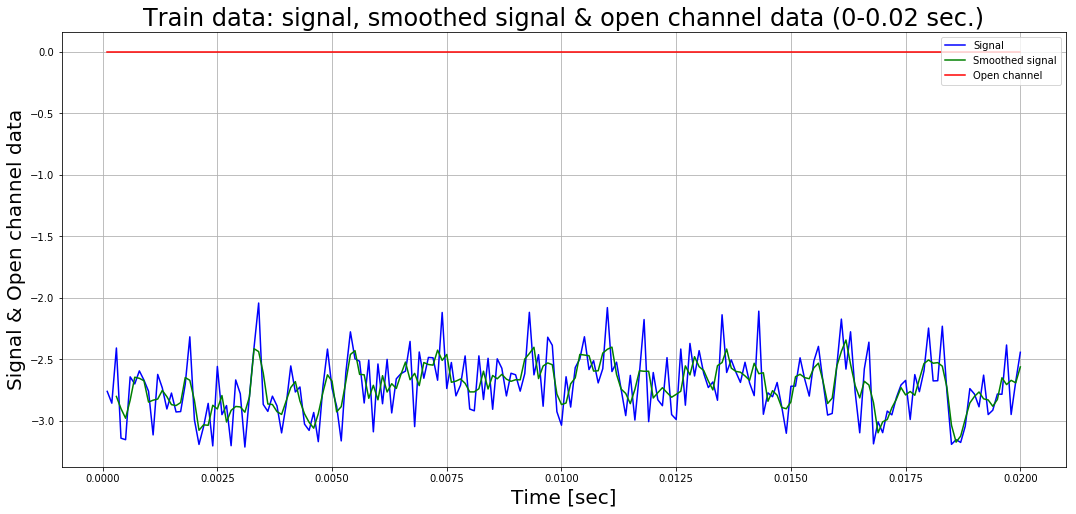

In [36]:
plot_signal_signal_smoothed_open_channel(train_df[0:200], "Train data: signal, smoothed signal & open channel data (0-0.02 sec.)")

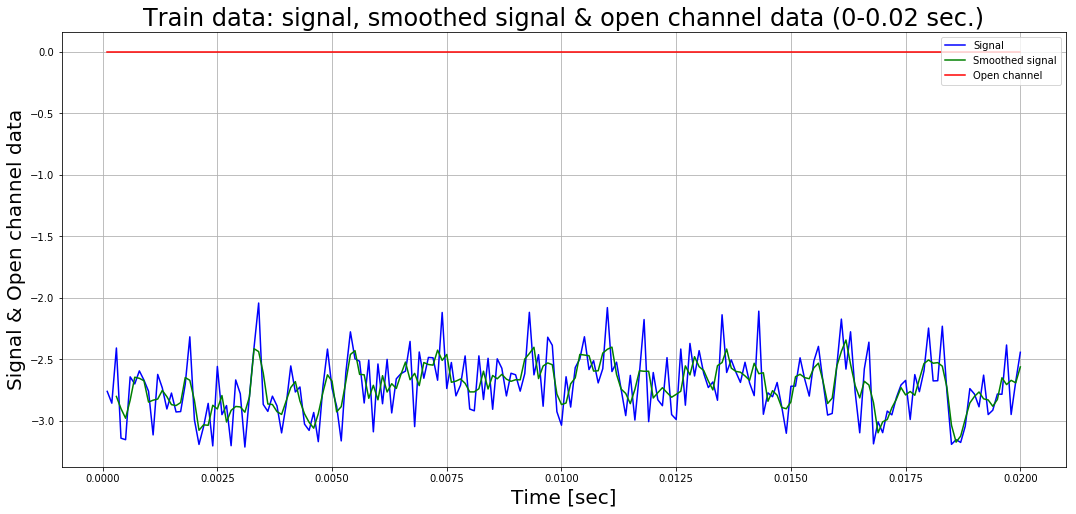

In [37]:
plot_signal_signal_smoothed_open_channel(train_df[0:200], "Train data: signal, smoothed signal & open channel data (0-0.02 sec.)")

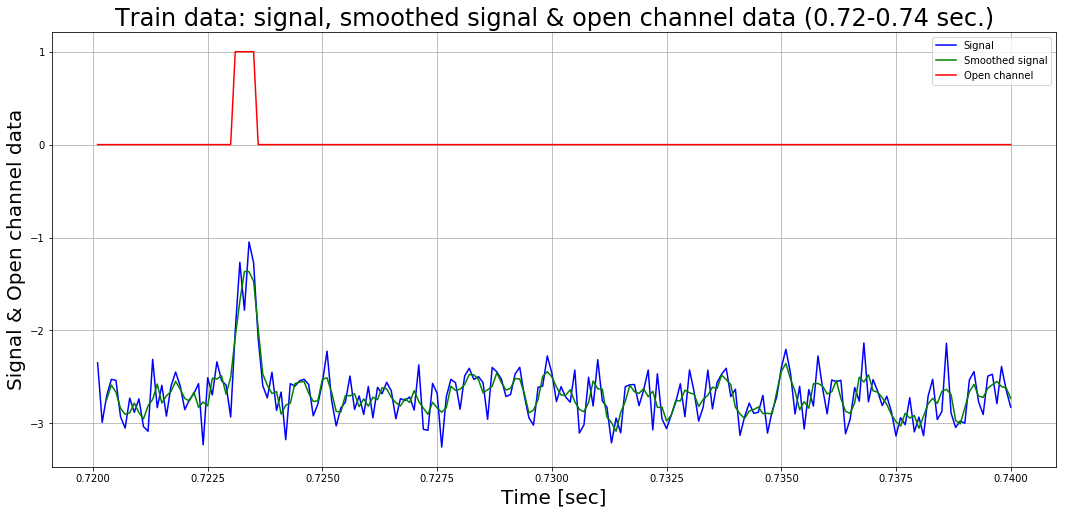

In [38]:
plot_signal_signal_smoothed_open_channel(train_df[7200:7400], "Train data: signal, smoothed signal & open channel data (0.72-0.74 sec.)")

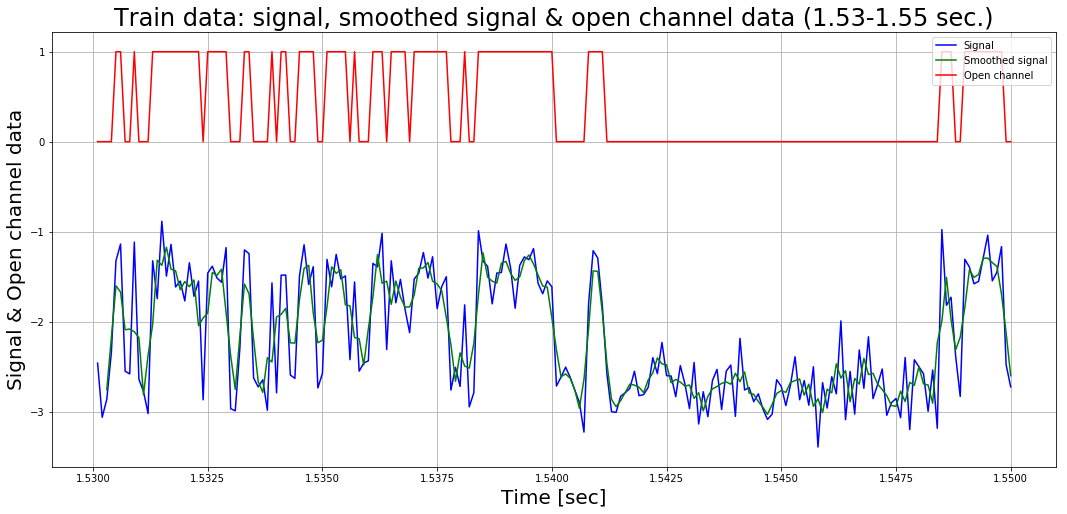

In [39]:
plot_signal_signal_smoothed_open_channel(train_df[15300:15500], "Train data: signal, smoothed signal & open channel data (1.53-1.55 sec.)")

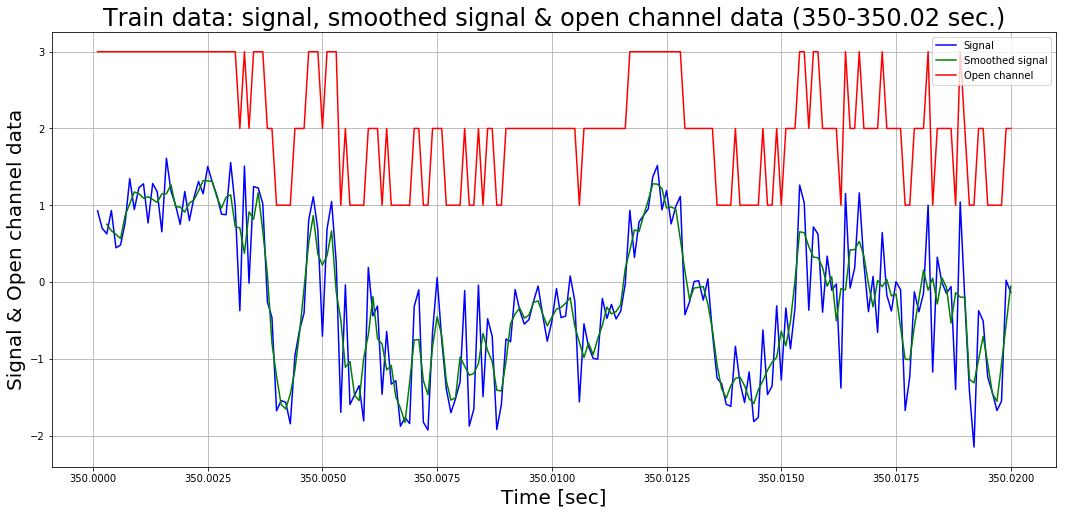

In [40]:
plot_signal_signal_smoothed_open_channel(train_df[3500000:3500200],'Train data: signal, smoothed signal & open channel data (350-350.02 sec.)')

# <a id='4'>Feature engineering</a>  

In [41]:
train_df['train'] = True
test_df['train'] = False
all_data = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)
all_data['train'] = all_data['train'].astype('bool')

all_data = all_data.sort_values(by=['time']).reset_index(drop=True)
all_data.index = ((all_data.time * 10_000) - 1).values
all_data['batch'] = all_data.index // 50_000
all_data['batch_index'] = all_data.index  - (all_data.batch * 50_000)
all_data['batch_slices'] = all_data['batch_index']  // 5_000
all_data['batch_slices2'] = all_data.apply(lambda r: '_'.join([str(r['batch']).zfill(3), str(r['batch_slices']).zfill(3)]), axis=1)

# 50_000 Batch Features
all_data['signal_batch_min'] = all_data.groupby('batch')['signal'].transform('min')
all_data['signal_batch_max'] = all_data.groupby('batch')['signal'].transform('max')
all_data['signal_batch_std'] = all_data.groupby('batch')['signal'].transform('std')
all_data['signal_batch_mean'] = all_data.groupby('batch')['signal'].transform('mean')
all_data['signal_batch_median'] = all_data.groupby('batch')['signal'].transform('median')
#all_data['signal_batch_mad'] = all_data.groupby('batch')['signal'].transform('mad')
all_data['signal_batch_skew'] = all_data.groupby('batch')['signal'].transform('skew')
all_data['mean_abs_chg_batch'] = all_data.groupby(['batch'])['signal'].transform(lambda x: np.mean(np.abs(np.diff(x))))
all_data['median_abs_chg_batch'] = all_data.groupby(['batch'])['signal'].transform(lambda x: np.median(np.abs(np.diff(x))))
all_data['abs_max_batch'] = all_data.groupby(['batch'])['signal'].transform(lambda x: np.max(np.abs(x)))
all_data['abs_min_batch'] = all_data.groupby(['batch'])['signal'].transform(lambda x: np.min(np.abs(x)))
all_data['abs_mean_batch'] = all_data.groupby(['batch'])['signal'].transform(lambda x: np.mean(np.abs(x)))
all_data['abs_median_batch'] = all_data.groupby(['batch'])['signal'].transform(lambda x: np.median(np.abs(x)))
all_data['moving_average_batch_1000_mean'] = all_data.groupby(['batch'])['signal'].rolling(window=1000).mean().mean(skipna=True)


all_data['range_batch'] = all_data['signal_batch_max'] - all_data['signal_batch_min']
all_data['maxtomin_batch'] = all_data['signal_batch_max'] / all_data['signal_batch_min']
all_data['abs_avg_batch'] = (all_data['abs_min_batch'] + all_data['abs_max_batch']) / 2

# 5_000 Batch Features
all_data['signal_batch_5k_min'] = all_data.groupby('batch_slices2')['signal'].transform('min')
all_data['signal_batch_5k_max'] = all_data.groupby('batch_slices2')['signal'].transform('max')
all_data['signal_batch_5k_std'] = all_data.groupby('batch_slices2')['signal'].transform('std')
all_data['signal_batch_5k_mean'] = all_data.groupby('batch_slices2')['signal'].transform('mean')
all_data['signal_batch_5k_median'] = all_data.groupby('batch_slices2')['signal'].transform('median')
all_data['signal_batch_5k_mad'] = all_data.groupby('batch_slices2')['signal'].transform('mad')
all_data['mean_abs_chg_batch_5k'] = all_data.groupby(['batch_slices2'])['signal'].transform(lambda x: np.mean(np.abs(np.diff(x))))
all_data['median_abs_chg_batch_5k'] = all_data.groupby(['batch'])['signal'].transform(lambda x: np.median(np.abs(np.diff(x))))
all_data['abs_max_batch_5k'] = all_data.groupby(['batch_slices2'])['signal'].transform(lambda x: np.max(np.abs(x)))
all_data['abs_min_batch_5k'] = all_data.groupby(['batch_slices2'])['signal'].transform(lambda x: np.min(np.abs(x)))
all_data['abs_mean_batch_5k'] = all_data.groupby(['batch_slices2'])['signal'].transform(lambda x: np.mean(np.abs(x)))
all_data['abs_median_batch_5k'] = all_data.groupby(['batch_slices2'])['signal'].transform(lambda x: np.median(np.abs(x)))

all_data['moving_average_batch_5k_1000_mean'] = all_data.groupby(['batch_slices2'])['signal'].rolling(window=1000).mean().mean(skipna=True)

all_data['range_batch_5k'] = all_data['signal_batch_5k_max'] - all_data['signal_batch_5k_min']
all_data['maxtomin_batch_5k'] = all_data['signal_batch_5k_max'] / all_data['signal_batch_5k_min']
all_data['abs_avg_batch_5k'] = (all_data['abs_min_batch_5k'] + all_data['abs_max_batch_5k']) / 2

#add shifts
all_data['signal_shift+1'] = all_data.groupby(['batch']).shift(1)['signal']
all_data['signal_shift-1'] = all_data.groupby(['batch']).shift(-1)['signal']
all_data['signal_shift+2'] = all_data.groupby(['batch']).shift(2)['signal']
all_data['signal_shift-2'] = all_data.groupby(['batch']).shift(-2)['signal']
#all_data['signal_shift+3'] = all_data.groupby(['batch']).shift(3)['signal']
#all_data['signal_shift-3'] = all_data.groupby(['batch']).shift(-3)['signal']

all_data['signal_shift+1_5k'] = all_data.groupby(['batch_slices2']).shift(1)['signal']
all_data['signal_shift-1_5k'] = all_data.groupby(['batch_slices2']).shift(-1)['signal']
all_data['signal_shift+2_5k'] = all_data.groupby(['batch_slices2']).shift(2)['signal']
all_data['signal_shift-2_5k'] = all_data.groupby(['batch_slices2']).shift(-2)['signal']
#all_data['signal_shift+3_5k'] = all_data.groupby(['batch_slices2']).shift(3)['signal']
#all_data['signal_shift-3_5k'] = all_data.groupby(['batch_slices2']).shift(-3)['signal']

all_data['abs_max_signal_shift+1_5k'] = all_data['signal_shift+1_5k'].transform(lambda x: np.max(np.abs(x)))
all_data['abs_max_signal_shift-1_5k'] = all_data['signal_shift-1_5k'].transform(lambda x: np.max(np.abs(x)))


Create additional features by substracting from a part of the engineered features the engineered signal.

In [42]:
for c in ['signal_batch_mean','signal_batch_median',
          'mean_abs_chg_batch','abs_max_batch','abs_min_batch', 'abs_median_batch',
          'moving_average_batch_1000_mean', 
          'range_batch','abs_avg_batch',
          'signal_batch_5k_mean', 'signal_batch_5k_median', 'signal_batch_5k_mad', 
          'moving_average_batch_5k_1000_mean', 
          'mean_abs_chg_batch_5k','abs_max_batch_5k', 'abs_min_batch_5k', 'abs_median_batch_5k', 
          'range_batch_5k','abs_avg_batch_5k',
          'signal_shift+1', 'signal_shift+2', 'signal_shift-1', 'signal_shift-2', #'signal_shift+3','signal_shift-3',
          'signal_shift+1_5k', 'signal_shift+2_5k', 'signal_shift-1_5k', 'signal_shift-2_5k', #'signal_shift+3_5k','signal_shift-3_5k',
          'abs_max_signal_shift+1_5k', 'abs_max_signal_shift-1_5k'
         ]:
    all_data[f'{c}_msignal'] = all_data[c] - all_data['signal']

In [43]:
FEATURES = [f for f in all_data.columns if f not in ['open_channels','index','time','train','batch',
                                                     'signal_batch_max', 'signal_batch_mad', 'maxtomin_batch'
                                                    'batch_index','batch_slices','batch_slices2', 'median_abs_chg_batch_5k',
                                                    'abs_mean_batch', 'abs_median_batch', 'abs_avg_batch', 'signal_batch_median',
                                                     'abs_max_batch', 'abs_max_batch_5k', 'abs_median_batch_5k', 
                                                    'moving_average_batch_1000_mean', 'moving_average_batch_5k_1000_mean']]
print('....: FEATURE LIST :....')
print([f for f in FEATURES])
print(f"Features: {len(FEATURES)}")

....: FEATURE LIST :....
['signal', 'batch_index', 'signal_batch_min', 'signal_batch_std', 'signal_batch_mean', 'signal_batch_skew', 'mean_abs_chg_batch', 'median_abs_chg_batch', 'abs_min_batch', 'range_batch', 'maxtomin_batch', 'signal_batch_5k_min', 'signal_batch_5k_max', 'signal_batch_5k_std', 'signal_batch_5k_mean', 'signal_batch_5k_median', 'signal_batch_5k_mad', 'mean_abs_chg_batch_5k', 'abs_min_batch_5k', 'abs_mean_batch_5k', 'range_batch_5k', 'maxtomin_batch_5k', 'abs_avg_batch_5k', 'signal_shift+1', 'signal_shift-1', 'signal_shift+2', 'signal_shift-2', 'signal_shift+1_5k', 'signal_shift-1_5k', 'signal_shift+2_5k', 'signal_shift-2_5k', 'abs_max_signal_shift+1_5k', 'abs_max_signal_shift-1_5k', 'signal_batch_mean_msignal', 'signal_batch_median_msignal', 'mean_abs_chg_batch_msignal', 'abs_max_batch_msignal', 'abs_min_batch_msignal', 'abs_median_batch_msignal', 'moving_average_batch_1000_mean_msignal', 'range_batch_msignal', 'abs_avg_batch_msignal', 'signal_batch_5k_mean_msignal', 

### Check memory

In [44]:
get_stats(all_data)

,na_count,n_unique,type,memory_usage
time,0,7000000,float64,53.4058
signal,0,137155,float64,53.4058
open_channels,2000000,12,float64,53.4058
train,0,2,bool,6.67572
batch,0,140,float64,53.4058
...,...,...,...,...
signal_shift-1_5k_msignal,1400,346569,float64,53.4058
signal_shift-2_5k_msignal,2800,377689,float64,53.4058
abs_max_signal_shift+1_5k_msignal,1400,381743,float64,53.4058
abs_max_signal_shift-1_5k_msignal,1400,381811,float64,53.4058


# <a id='5'>Model</a>  

In [45]:
TARGET = 'open_channels'
all_data['train'] = all_data['train'].astype('bool')
train_df = all_data.query('train').copy()
test_df = all_data.query('not train').copy()
train_df['open_channels'] = train_df['open_channels'].astype(int)
X = train_df[FEATURES]
X_test = test_df[FEATURES]
y = train_df[TARGET].values
sub = test_df[['time']].copy()
groups = train_df['batch']
oof_df = train_df[['signal','open_channels']].copy()

### Release memory

In [46]:
del all_data
del train_df
del test_df
gc.collect()

0

In [47]:

TOTAL_FOLDS = 5

MODEL_TYPE = 'LGBM'
SHUFFLE = True
NUM_BOOST_ROUND = 2_200
EARLY_STOPPING_ROUNDS = 50
VERBOSE_EVAL = 100
RANDOM_SEED = 31452


params = {'learning_rate': 0.02,
          'max_depth': -1,
          'num_leaves': 2**8+1,
          'feature_fraction': 0.85,
          'bagging_fraction': 0.85,
          'bagging_freq': 0,
          'n_jobs': 8,
          'seed': RANDOM_SEED,
          'metric': 'rmse',
          'objective' : 'regression',
          'num_class': 1
        }

kfold = KFold(n_splits=TOTAL_FOLDS, shuffle=SHUFFLE, random_state=RANDOM_SEED)

feature_importance_df = pd.DataFrame()

fold_ = 1 
for tr_idx, val_idx in kfold.split(X, y, groups=groups):
    print(f'====== Fold {fold_:0.0f} of {TOTAL_FOLDS} ======')
    X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_val = y[tr_idx], y[val_idx]
    train_set = lgb.Dataset(X_tr, y_tr)
    val_set = lgb.Dataset(X_val, y_val)

    model = lgb.train(params,
                      train_set,
                      num_boost_round = NUM_BOOST_ROUND,
                      early_stopping_rounds = EARLY_STOPPING_ROUNDS,
                      valid_sets = [train_set, val_set],
                      verbose_eval = VERBOSE_EVAL)

    preds = model.predict(X_val, num_iteration=model.best_iteration)
    preds = np.round(np.clip(preds, 0, 10)).astype(int)
    test_preds = model.predict(X_test, num_iteration=model.best_iteration)
    test_preds = np.round(np.clip(test_preds, 0, 10)).astype(int)

    oof_df.loc[oof_df.iloc[val_idx].index, 'oof'] = preds
    sub[f'open_channels_fold{fold_}'] = test_preds

    f1 = f1_score(oof_df.loc[oof_df.iloc[val_idx].index]['open_channels'],
                  oof_df.loc[oof_df.iloc[val_idx].index]['oof'],
                            average = 'macro')
    rmse = np.sqrt(mean_squared_error(oof_df.loc[oof_df.index.isin(val_idx)]['open_channels'],
                                      oof_df.loc[oof_df.index.isin(val_idx)]['oof']))

    
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = FEATURES
    fold_importance_df["importance"] = model.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    print(f'Fold {fold_} - validation f1: {f1:0.5f}')
    print(f'Fold {fold_} - validation rmse: {rmse:0.5f}')

    fold_ += 1

oof_f1 = f1_score(oof_df['open_channels'],
                    oof_df['oof'],
                    average = 'macro')
oof_rmse = np.sqrt(mean_squared_error(oof_df['open_channels'],
                                      oof_df['oof']))

====== Fold 1 of 5 ======
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.390653	valid_1's rmse: 0.391799
[200]	training's rmse: 0.168083	valid_1's rmse: 0.17077
[300]	training's rmse: 0.158647	valid_1's rmse: 0.162274
[400]	training's rmse: 0.156851	valid_1's rmse: 0.16139
[500]	training's rmse: 0.155732	valid_1's rmse: 0.161098
[600]	training's rmse: 0.1548	valid_1's rmse: 0.160939
[700]	training's rmse: 0.154008	valid_1's rmse: 0.160832
[800]	training's rmse: 0.153266	valid_1's rmse: 0.160739
[900]	training's rmse: 0.152578	valid_1's rmse: 0.160692
[1000]	training's rmse: 0.1519	valid_1's rmse: 0.160636
[1100]	training's rmse: 0.151253	valid_1's rmse: 0.160582
[1200]	training's rmse: 0.150641	valid_1's rmse: 0.160544
[1300]	training's rmse: 0.150018	valid_1's rmse: 0.160515
[1400]	training's rmse: 0.149422	valid_1's rmse: 0.160489
[1500]	training's rmse: 0.14882	valid_1's rmse: 0.16047
[1600]	training's rmse: 0.148241	valid_1's rmse: 0.160448
[1

Let's plot the feature importance.

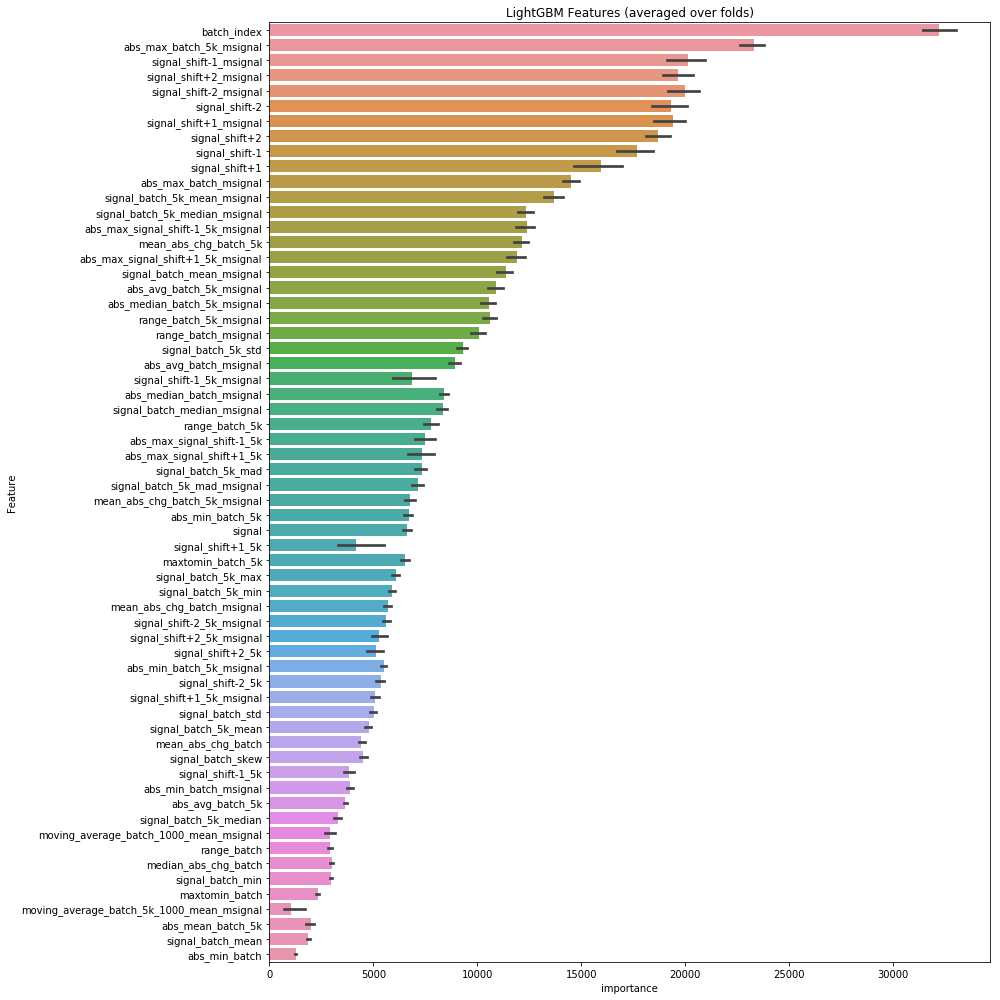

In [48]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:100].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,14))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

# <a id='6'>Submission</a>  

In [49]:
s_cols = [s for s in sub.columns if 'open_channels' in s]

sub['open_channels'] = sub[s_cols].median(axis=1).astype(int)
sub[['time','open_channels']].to_csv('./submission.csv',
        index=False,
        float_format='%0.4f')

# <a id='7'>References</a>  

[1] University of Liverpool - Ion Switching, Identify the number of channels open at each time point, Competition introduction, https://www.kaggle.com/c/liverpool-ion-switching  
[2] Ion channel, Wikipedia article, https://en.wikipedia.org/wiki/Ion_channel